Experiment 5: Extending the DiCE genetic framework for SEP Counterfactual Explanation generation

Objective: This notebook builds a custom constrained genetic counterfactual generator on top of DiCE, enforces domain-specific rules (P3 > P5 > P7 + permitted ranges), generates counterfactuals for a Random Forest classifier, and evaluates their validity and predictive alignment.

In [35]:
import wandb
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from dice_ml.explainer_interfaces.explainer_base import UserConfigValidationException
import plotly.graph_objects as go
from datetime import timedelta
import os
import re
import joblib
from PIL import Image
import matplotlib.dates as mdates

from scripts.SEP_CFE_DiCE.SEP_CFE_Analyzer import  CFEAnalyzer
from scripts.SEP_CFE_functions import *
min_max_scaler = MinMaxScaler()
warnings.filterwarnings("ignore")

In [36]:
# wandb.init(
#     entity="gsu-dmlab",
#     project="SEPCFE",  # You choose the project name
#     name="Exp5_Custom_Extension_of_DiCE_Genetic_Framework",  # Give each run a name
#     config={
#         "model": "RandomForestClassifier_model_sep_cfe.pkl",
#         "data_version": "mean_sliced",
#         "explainer_random": "sep_cfe_random_explainer.pkl",
#         "explainer_genetic": "sep_cfe_genetic_explainer.pkl",
#         "Constrained explainer":"ConstrainedDiceGenetic"
#     }
# )

Constrained Dice Explainer Class

In [37]:
from dice_ml.explainer_interfaces.dice_genetic import DiceGenetic
import numpy as np

class ConstrainedDiceGenetic(DiceGenetic):
    def __init__(self, data_interface, model_interface,
                 permitted_range_dict, ordering_penalty=1e4, **kwargs):
        super().__init__(data_interface, model_interface, **kwargs)
        self.permitted_range_dict = permitted_range_dict
        self.ordering_penalty = ordering_penalty

        # Identify all windows from the permitted_range_dict
        self.windows = []
        for fname in permitted_range_dict:
            if fname.startswith('p3_flux_ic_mean@'):
                window = fname.split('@')[1]
                self.windows.append(window)

        # Build feature name mapping for each window
        self.feature_triplets = []
        for window in self.windows:
            p3 = f'p3_flux_ic_mean@{window}'
            p5 = f'p5_flux_ic_mean@{window}'
            p7 = f'p7_flux_ic_mean@{window}'
            if (p3 in data_interface.feature_names and
                p5 in data_interface.feature_names and
                p7 in data_interface.feature_names):
                self.feature_triplets.append((p3, p5, p7))

        # Build index mapping for fast access
        self.feature_indices = []
        for p3, p5, p7 in self.feature_triplets:
            idx3 = data_interface.feature_names.index(p3)
            idx5 = data_interface.feature_names.index(p5)
            idx7 = data_interface.feature_names.index(p7)
            self.feature_indices.append((idx3, idx5, idx7))

    def _ordering_constraint_penalty(self, candidates):
        """
        Returns a penalty array: 0 if p3 > p5 > p7 for ALL windows, else large penalty.
        """
        penalty = np.zeros(candidates.shape[0])
        for idx3, idx5, idx7 in self.feature_indices:
            p3 = candidates[:, idx3]
            p5 = candidates[:, idx5]
            p7 = candidates[:, idx7]
            violations = (p3 >= 10) | (p3 <= p5) | (p5 <= p7)
            penalty += violations.astype(float) * self.ordering_penalty
        return penalty

    def _range_constraint_penalty(self, candidates):
        """
        Returns penalty if any value is out of permitted range for any feature.
        """
        penalty = np.zeros(candidates.shape[0])
        for fname, (fmin, fmax) in self.permitted_range_dict.items():
            if fname in self.data_interface.feature_names:
                idx = self.data_interface.feature_names.index(fname)
                vals = candidates[:, idx]
                out_of_bounds = (vals < fmin) | (vals > fmax)
                penalty += out_of_bounds.astype(float) * self.ordering_penalty
        return penalty

    def _fitness_fn(self, candidates, query_instance, desired_class, **kwargs):
        """
        Override the fitness function to include ordering and range penalties.
        """
        # Original fitness (lower is better)
        fitness = super()._fitness_fn(candidates, query_instance, desired_class, **kwargs)
        # Add ordering constraint penalty
        fitness += self._ordering_constraint_penalty(candidates)
        # Add range constraint penalty
        fitness += self._range_constraint_penalty(candidates)
        return fitness


In [38]:
DATA_DIR="/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/mean_sliced"

In [39]:
abt_path_train = DATA_DIR+'/train_data.csv'
df_train = pd.read_csv(abt_path_train,  sep=',',index_col=0)
abt_path_test = DATA_DIR+'/test_data.csv'
df_test = pd.read_csv(abt_path_test, sep=',',index_col=0)
abt_path_val = DATA_DIR+'/valid_data.csv'
df_val = pd.read_csv(abt_path_val, sep=',',index_col=0)

In [40]:
DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/SEP"
X_train=pd.read_csv(DATA_DIR+'/X_train.csv',sep=',',index_col=0)
Y_train=pd.read_csv(DATA_DIR+'/Y_train.csv',sep=',',index_col=0)
X_test=pd.read_csv(DATA_DIR+'/X_test.csv',sep=',',index_col=0)
Y_test=pd.read_csv(DATA_DIR+'/Y_test.csv',sep=',',index_col=0)
X_val=pd.read_csv(DATA_DIR+'/X_val.csv',sep=',',index_col=0)
Y_val=pd.read_csv(DATA_DIR+'/Y_val.csv',sep=',',index_col=0)
# df_multi_labels = pd.read_excel("../data/raw/multi_labels.xlsx",header=0)
# df_multi_labels = df_multi_labels[df_multi_labels['File'] != '1991-06-18_23-16.csv']
df_combined_labels=pd.read_csv(DATA_DIR+'/df_combined_labels.csv',sep=',',index_col=0)


In [41]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# all_entries = os.listdir('../data/raw/data/')        # no wildcard here
# csv_files = [f for f in all_entries if f.lower().endswith('.csv')]
# df_combined_labels['not_exists'] = ~df_combined_labels['File'].str.lower().isin(csv_files)
# missing = df_combined_labels[df_combined_labels['not_exists']]
# print(missing[['File', 'not_exists','Label','Event_Y_N']])
# print(df_combined_labels.shape)


In [42]:
# Load model
best_rf = joblib.load('/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/RandomForestClassifier_model_sep_cfe.pkl')
Y_pred = best_rf.predict(X_train)
#
# # Output the test classification report and confusion matrix
# print("\nTest Classification Report:\n", classification_report(Y_train, Y_pred))
# print("Test Confusion Matrix:\n", confusion_matrix(Y_train, Y_pred))

**Counterfactual Explainations for SEP Prediction**

In [43]:
df_cfe = df_test.drop(["Label"],axis=1)
#df_cfe = df_combined_labels.drop(["Label","File","Label.1"],axis=1)  # should contain the target column
cont_features = list(df_combined_labels.drop(["Label","Event_Y_N","File","Multi_Label"],axis=1).columns) #should not contain target column
feature_names = X_train.columns

In [44]:
exp_random = joblib.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_random_explainer.pkl")
exp_genetic = joblib.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction//models/sep_cfe_genetic_explainer.pkl")

In [45]:
sep_cfe_analyzer1=CFEAnalyzer(best_rf,feature_names)
# sep_cfe_analyzer1.get_feature_importance()

In [46]:
k=928
sorted_normalized_weights_df  = get_feature_importance(best_rf,feature_names)
top_k_features = sorted_normalized_weights_df['Feature'].head(k).to_list()
top_k_normalized_weights_dict = sorted_normalized_weights_df.head(k).set_index('Feature')['Normalized Importance'].to_dict()
print(top_k_normalized_weights_dict)


{'p3_flux_ic_mean@[345:351]': 0.016813218692665145, 'p3_flux_ic_mean@[294:306]': 0.015512243536081334, 'p3_flux_ic_mean@[180:360]': 0.013845563113781103, 'p3_flux_ic_mean@[336:342]': 0.013481700224440563, 'p3_flux_ic_mean@[336:359]': 0.011833220526009637, 'p3_flux_ic_mean@[306:312]': 0.011426146862369906, 'p3_flux_ic_mean@[336:348]': 0.010816571712953494, 'p3_flux_ic_mean@[354:360]': 0.01034312660313399, 'p3_flux_ic_mean@[300:323]': 0.00973025424545855, 'long_mean@[324:336]': 0.009371275130185179, 'long_mean@[324:347]': 0.009296114622546137, 'p3_flux_ic_mean@[342:348]': 0.009174061176106618, 'p3_flux_ic_mean@[351:357]': 0.009125568694259279, 'p3_flux_ic_mean@[204:216]': 0.009033125189585219, 'p3_flux_ic_mean@[324:347]': 0.008997399971114345, 'p3_flux_ic_mean@[327:333]': 0.008828405668376298, 'p3_flux_ic_mean@[348:360]': 0.008497467075116196, 'p3_flux_ic_mean@[306:318]': 0.007659297114032558, 'p3_flux_ic_mean@[324:330]': 0.007370584572652871, 'p3_flux_ic_mean@[204:227]': 0.0073415306547

In [47]:
p3_flux_cols = [col for col in df_train.columns if 'p3_flux_ic_mean' in col]
p5_flux_cols = [col for col in df_train.columns if 'p5_flux_ic_mean' in col]
p7_flux_cols = [col for col in df_train.columns if 'p7_flux_ic_mean' in col]


In [48]:
pattern = r'^(p3_flux_ic_mean|p5_flux_ic_mean|p7_flux_ic_mean|long_mean)@\[(\d+:\d+)\]$'
header_list = df_train.columns.astype(str).str.cat(sep="\t").split()
slices = extract_slices_from_headers(header_list,pattern,"p3_flux_ic_mean")


In [49]:
from sklearn.metrics import confusion_matrix
def TSS(y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel()
    return  (TP / (TP + FN) - FP / (FP + TN))
def HSS(y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel()
    return 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))

Initialization of Constrained Dice Explainer

In [50]:
import dice_ml
df_train["Event_Y_N"] = df_train['Label'].replace({0:1, -1:0})
cont_features = list(df_train.drop(["Label","Event_Y_N"],axis=1).columns)

df_cfe = df_train.drop("Label",axis=1)
data= dice_ml.Data(dataframe=df_cfe, continuous_features=cont_features, outcome_name='Event_Y_N')
cfe_model = dice_ml.Model(model=best_rf, backend="sklearn", model_type='classifier')
#Create the Dice explainer
exp = dice_ml.Dice(data_interface=data, model_interface=cfe_model, method="genetic") #method= ["genetic","kdtree","random"]

In [51]:
# explainer = ConstrainedDiceGenetic(
#     data_interface=data,
#     model_interface=cfe_model,
#     permitted_range_dict={},
#     ordering_penalty=1e2  # Tune as needed
# )

Generate counterfactuals

In [52]:
query_files = [
    '2017-10-20_22-10.csv',
    '2017-09-09_21-04.csv',
    '2015-06-12_22-32.csv',
    '2005-01-19_18-40.csv',
    '2003-05-30_16-25.csv',
    '2004-09-19_07-25.csv',
    '2003-11-20_18-08.csv'
]

# Directory paths
CSV_DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/data/"
OUTPUT_PATH = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/all_counterfactuals_genetic_pgcfe.csv"

# Storage for all CFs
cfe_exp = []

for qfile in query_files:
    print(f"\nProcessing file: {qfile}")
    csv_path = os.path.join(CSV_DATA_DIR, qfile)

    try:
        # 1. Get query instance and predictions
        query_instance, class_label, predicted_label = get_query_instance(
            qfile,
            df_combined_labels=df_combined_labels,
            model=best_rf
        )

        # 2. Determine target counterfactual label (opposite of predicted)
        cfe_label = 0 if predicted_label[0] == 1 else 1
        print(f"   Predicted label: {predicted_label[0]}, Target CF label: {cfe_label}")

        # 3. Extract permitted feature ranges dynamically from CSV
        permitted_range_dict = extract_feature_ranges(
            csv_path,
            delim=',',
            slices=slices,
            top_k_features=top_k_features,
            flux_types=['p3_flux_ic', 'p5_flux_ic', 'p7_flux_ic']
        )

        print(f"   Permitted range dictionary created with {len(permitted_range_dict)} entries")
        explainer = ConstrainedDiceGenetic(
            data_interface=data,
            model_interface=cfe_model,
            permitted_range_dict=permitted_range_dict,
            ordering_penalty=1e2  # Tune as needed
        )

        # 4. Generate counterfactuals using explainer
        cf = explainer.generate_counterfactuals(
            query_instances=query_instance,
            total_CFs=1,
            permitted_range_dict=permitted_range_dict,  # dynamically injected
            desired_class=cfe_label
        )

        # 5. Extract CF dataframe
        df_cf = cf.cf_examples_list[0].final_cfs_df.copy()
        df_cf["file"] = qfile
        df_cf["original_label"] = predicted_label[0]
        df_cf["target_label"] = cfe_label

        # 6. Append to combined list
        cfe_exp.append(df_cf)
        print(f"   Counterfactual generated successfully for {qfile}")

    except Exception as e:
        print(f"Skipping {qfile} due to error: {e}")

# 7. Combine all CFs into a single DataFrame
if cfe_exp:
    df_cfe_exp_genetic_all = pd.concat(cfe_exp, ignore_index=True)
    df_cfe_exp_genetic_all.to_csv(OUTPUT_PATH, index=False)
    print(f"\nCombined all CFEs successfully. Saved to {OUTPUT_PATH}")
else:
    print("\nNo counterfactuals were generated.")



Processing file: 2017-10-20_22-10.csv
Target value for the query instance:
 0.0
Predicted value:
 [0]
   Predicted label: 0, Target CF label: 1
   Permitted range dictionary created with 696 entries


  0%|          | 0/1 [00:00<?, ?it/s]

Skipping 2017-10-20_22-10.csv due to error: _generate_counterfactuals() got an unexpected keyword argument 'permitted_range_dict'

Processing file: 2017-09-09_21-04.csv
Target value for the query instance:
 1.0
Predicted value:
 [0]
   Predicted label: 0, Target CF label: 1


   Permitted range dictionary created with 696 entries


  0%|          | 0/1 [00:00<?, ?it/s]


Skipping 2017-09-09_21-04.csv due to error: _generate_counterfactuals() got an unexpected keyword argument 'permitted_range_dict'

Processing file: 2015-06-12_22-32.csv
Target value for the query instance:
 0.0
Predicted value:
 [0]
   Predicted label: 0, Target CF label: 1
   Permitted range dictionary created with 696 entries


  0%|          | 0/1 [00:00<?, ?it/s]

Skipping 2015-06-12_22-32.csv due to error: _generate_counterfactuals() got an unexpected keyword argument 'permitted_range_dict'

Processing file: 2005-01-19_18-40.csv
Target value for the query instance:
 0.0
Predicted value:
 [0]
   Predicted label: 0, Target CF label: 1
   Permitted range dictionary created with 696 entries



  0%|          | 0/1 [00:00<?, ?it/s]

Skipping 2005-01-19_18-40.csv due to error: _generate_counterfactuals() got an unexpected keyword argument 'permitted_range_dict'

Processing file: 2003-05-30_16-25.csv
Target value for the query instance:
 0.0
Predicted value:
 [1]
   Predicted label: 1, Target CF label: 0


   Permitted range dictionary created with 696 entries


  0%|          | 0/1 [00:00<?, ?it/s]


Skipping 2003-05-30_16-25.csv due to error: _generate_counterfactuals() got an unexpected keyword argument 'permitted_range_dict'

Processing file: 2004-09-19_07-25.csv
Target value for the query instance:
 0.0
Predicted value:
 [0]
   Predicted label: 0, Target CF label: 1
   Permitted range dictionary created with 696 entries


  0%|          | 0/1 [00:00<?, ?it/s]

Skipping 2004-09-19_07-25.csv due to error: _generate_counterfactuals() got an unexpected keyword argument 'permitted_range_dict'

Processing file: 2003-11-20_18-08.csv
Target value for the query instance:
 1.0
Predicted value:
 [1]
   Predicted label: 1, Target CF label: 0


   Permitted range dictionary created with 696 entries


  0%|          | 0/1 [00:00<?, ?it/s]

Skipping 2003-11-20_18-08.csv due to error: _generate_counterfactuals() got an unexpected keyword argument 'permitted_range_dict'

No counterfactuals were generated.



Processing file: 2017-10-20_22-10.csv


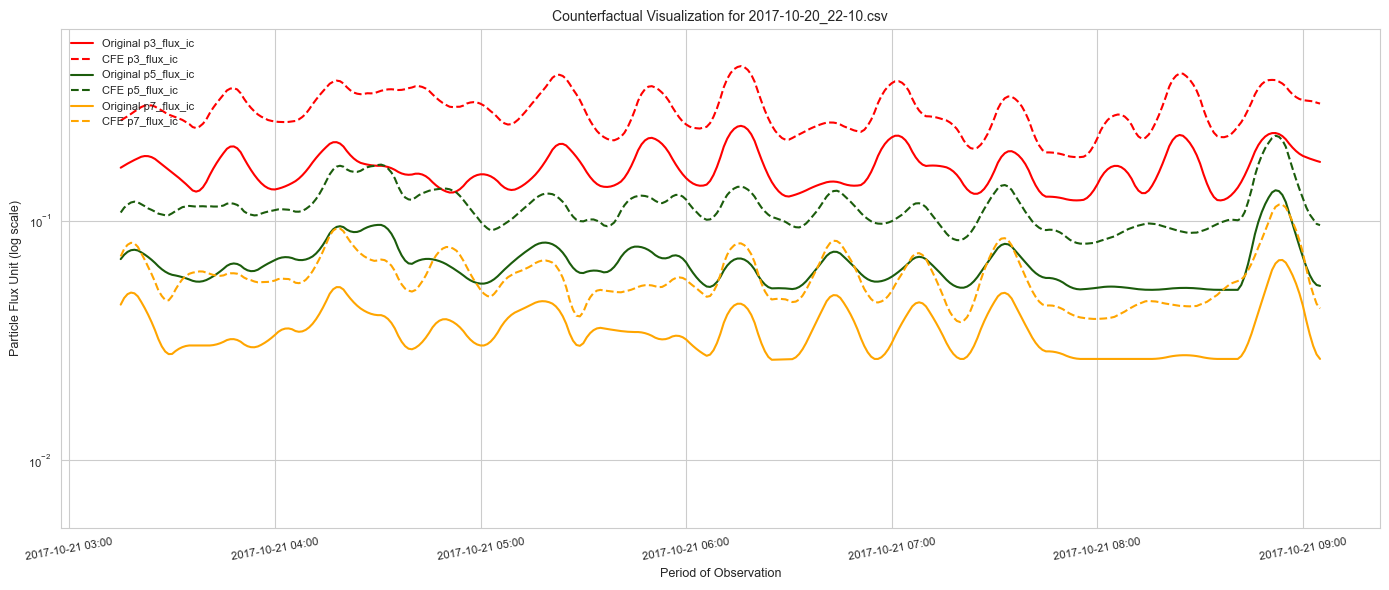

Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_single/CFE_2017-10-20_22-10.png

Processing file: 2017-09-09_21-04.csv


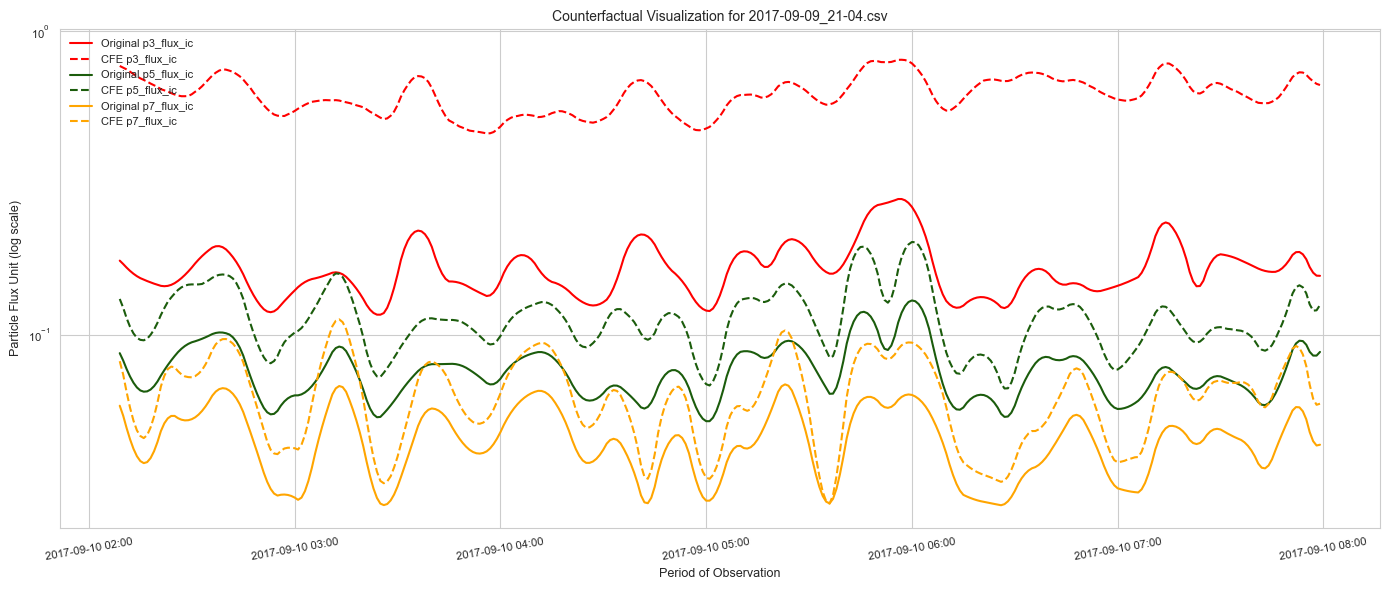

Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_single/CFE_2017-09-09_21-04.png

Processing file: 2015-06-12_22-32.csv


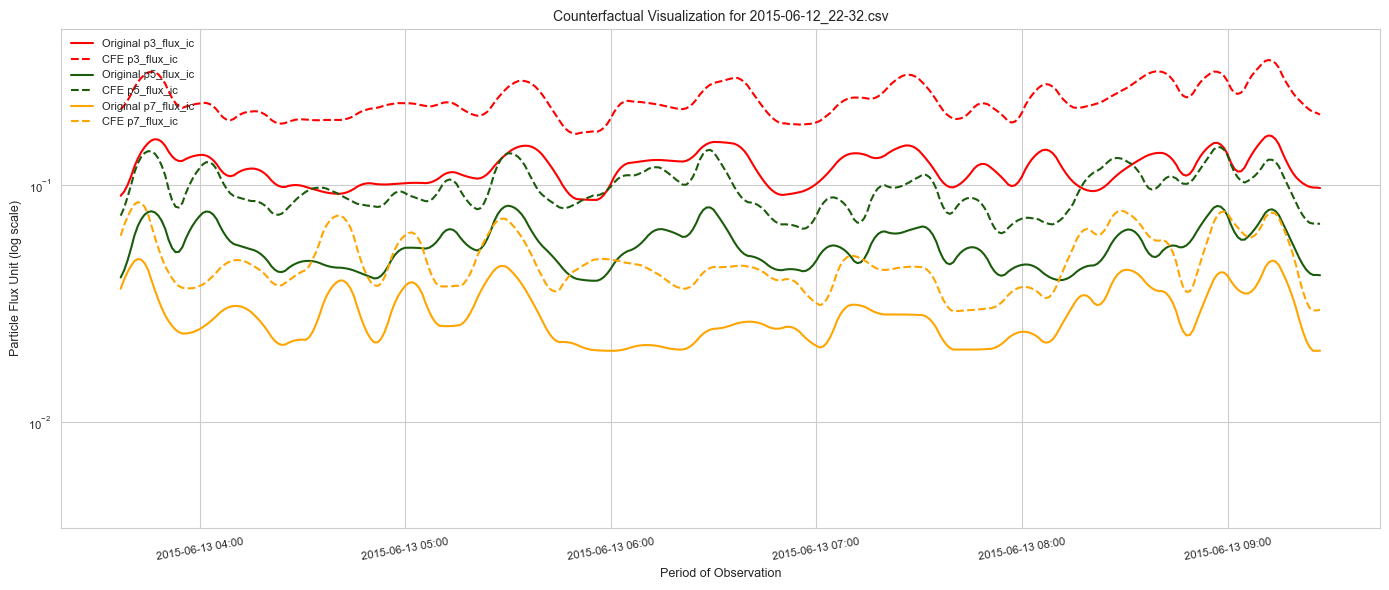

Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_single/CFE_2015-06-12_22-32.png

Processing file: 2005-01-19_18-40.csv


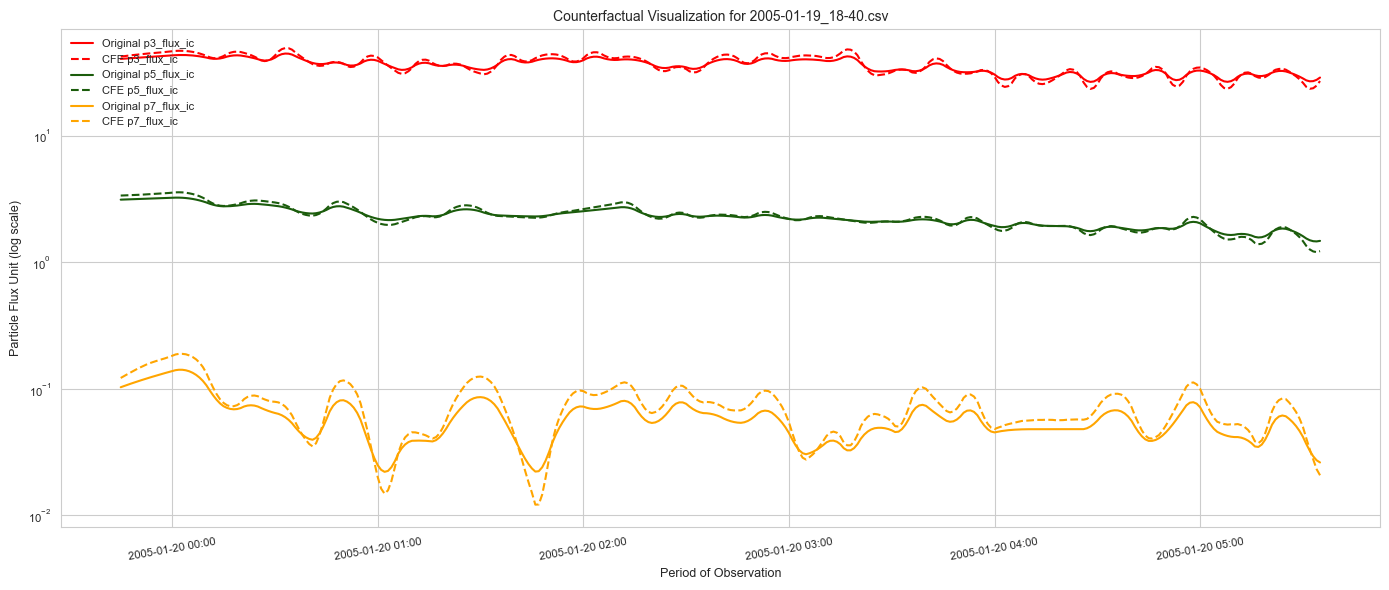

Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_single/CFE_2005-01-19_18-40.png

Processing file: 2003-05-30_16-25.csv


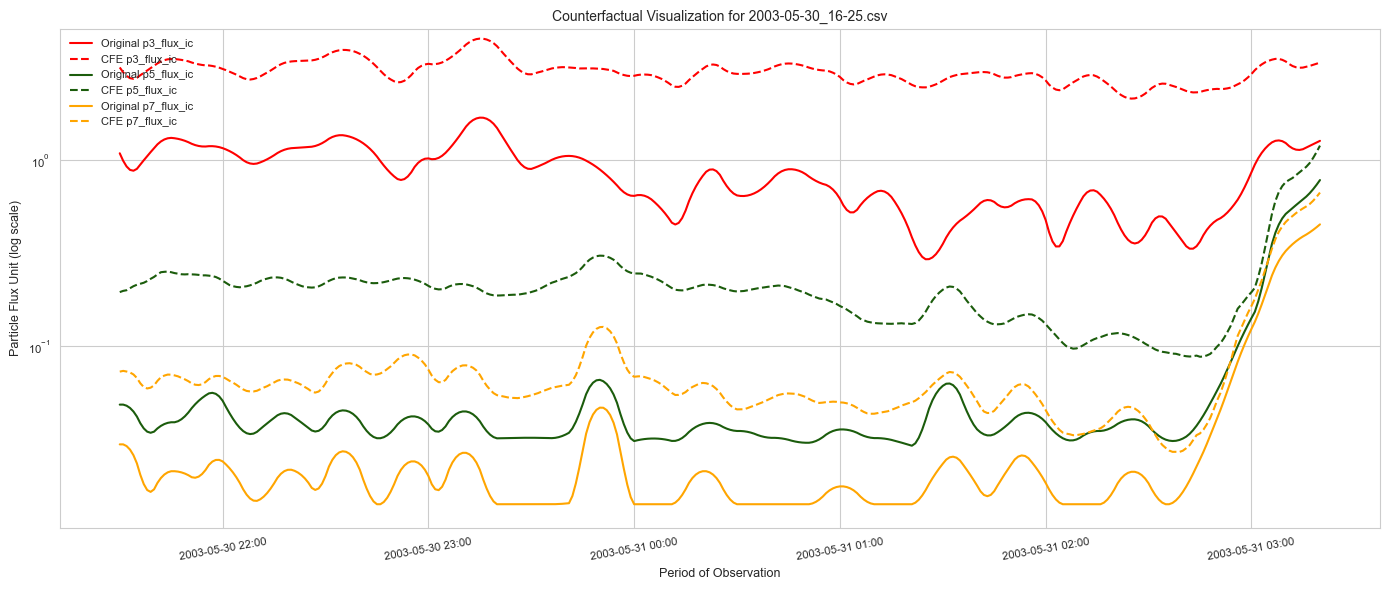

Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_single/CFE_2003-05-30_16-25.png

Processing file: 2004-09-19_07-25.csv


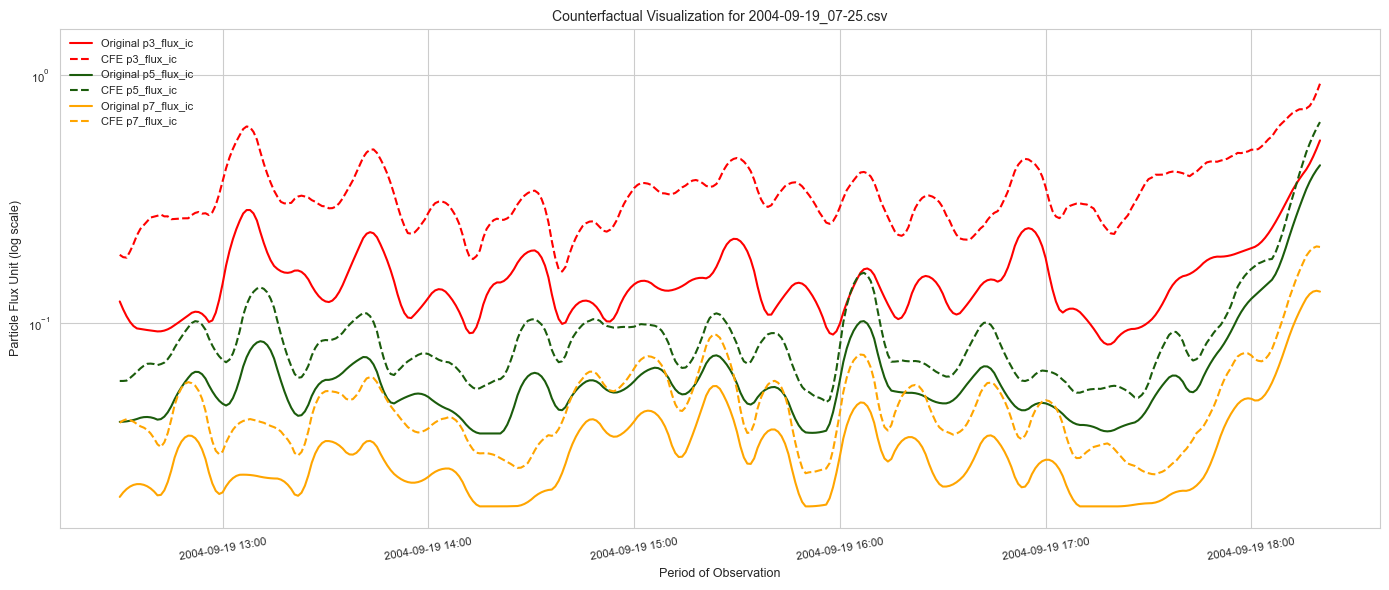

Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_single/CFE_2004-09-19_07-25.png

Processing file: 2003-11-20_18-08.csv


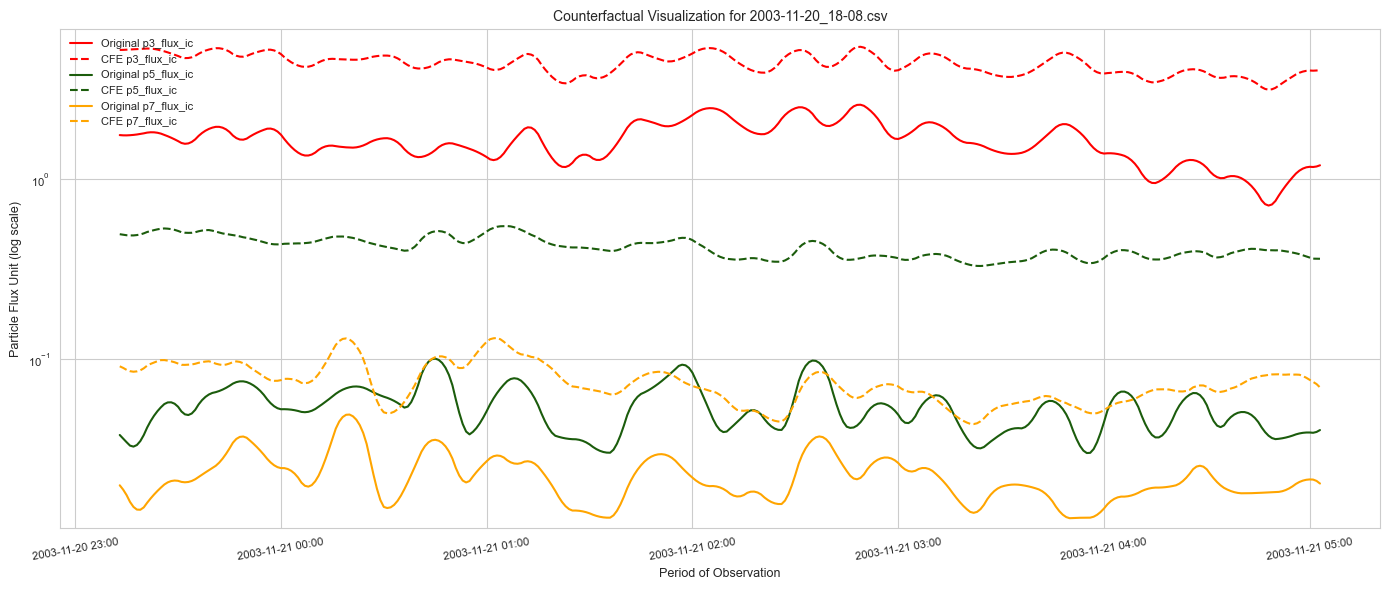

Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_single/CFE_2003-11-20_18-08.png


In [53]:
import matplotlib.pyplot as plt


window_size = 10
CSV_DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/data/"
SAVE_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_single"
os.makedirs(SAVE_DIR, exist_ok=True)

for file_name in df_cfe_exp_genetic_all["file"].unique():
    print(f"\nProcessing file: {file_name}")
    csv_path = os.path.join(CSV_DATA_DIR, file_name)

    # Get the first (or only) counterfactual for this file
    df_file = df_cfe_exp_genetic_all[df_cfe_exp_genetic_all["file"] == file_name].reset_index(drop=True)
    if df_file.empty:
        print(f"No CFEs found for {file_name}")
        continue

    sample_cfe = df_file.iloc[0]  # pick first CFE
    fig, ax = plt.subplots(figsize=(14, 6), facecolor='white')
    ax.set_facecolor('white')

    flux_channels = ['p3_flux_ic', 'p5_flux_ic', 'p7_flux_ic']
    colors = {'p3_flux_ic': '#FF0000', 'p5_flux_ic': '#1b5c0c', 'p7_flux_ic': '#FFA500'}
    y_mins, y_maxs = [], []

    for flux_type in flux_channels:
        df_obs, final_series, original, min_y, max_y = get_pertubed_series(
            csv_path, sample_cfe=sample_cfe, flux_type=flux_type,
            slices=slices, start_offset_min=300, end_offset_min=660
        )

        orig_smooth = original.rolling(window=window_size, center=True).mean()
        cf_smooth = pd.Series(final_series).rolling(window=window_size, center=True).mean()

        ax.plot(df_obs["time_stamp"], orig_smooth,
                label=f"Original {flux_type}", color=colors[flux_type])
        ax.plot(df_obs["time_stamp"], cf_smooth,
                label=f"CFE {flux_type}", color=colors[flux_type], linestyle='dashed')

        y_mins.append(min_y)
        y_maxs.append(max_y)

    global_min_y = min(y_mins)
    global_max_y = max(y_maxs)

    ax.set_xlabel("Period of Observation", fontsize=9)
    ax.set_ylabel("Particle Flux Unit (log scale)", fontsize=9)
    ax.set_yscale('log')
    ax.set_ylim(global_min_y * 0.9, global_max_y * 1.1)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=10, ha='center', fontsize=8)
    plt.setp(ax.get_yticklabels(), fontsize=8)

    ax.legend(loc='upper left', frameon=False, fontsize=8)
    ax.set_title(f"Counterfactual Visualization for {file_name}", fontsize=10)

    plt.tight_layout()
    plt.show()

    # Optionally log or save figure
    try:
        wandb.log({f"CFE_visual_{file_name}": wandb.Image(fig)})
    except Exception:
        pass

    save_path = os.path.join(SAVE_DIR, f"CFE_{os.path.splitext(file_name)[0]}.png")
    fig.savefig(save_path, bbox_inches="tight", dpi=200)
    plt.close(fig)
    print(f"Saved: {save_path}")


In [54]:
explainer2 = ConstrainedDiceGenetic(
    data_interface=data,
    model_interface=cfe_model,
    permitted_range_dict=filtered_dict_2,
    ordering_penalty=1e2  # Tune as needed
)

# Generate counterfactuals
cf2 = explainer.generate_counterfactuals(
    query_instances=query_instance2,
    total_CFs=4,
    desired_class=0
)

NameError: name 'filtered_dict_2' is not defined

In [128]:
cfe_exp = []  # Initialize the list before the loop

cfe_df = cf2.cf_examples_list[0].final_cfs_df
cfe_exp.append(cfe_df)  # Append each DataFrame

# Concatenate once after the loop
df_cfe_exp_genetic_2 = pd.concat(cfe_exp, ignore_index=True)
df_cfe_exp_genetic_2.drop_duplicates()


,p3_flux_ic_mean@[0:360],p5_flux_ic_mean@[0:360],p7_flux_ic_mean@[0:360],long_mean@[0:360],p3_flux_ic_mean@[0:180],p5_flux_ic_mean@[0:180],p7_flux_ic_mean@[0:180],long_mean@[0:180],p3_flux_ic_mean@[90:270],p5_flux_ic_mean@[90:270],p7_flux_ic_mean@[90:270],long_mean@[90:270],p3_flux_ic_mean@[180:360],p5_flux_ic_mean@[180:360],p7_flux_ic_mean@[180:360],long_mean@[180:360],p3_flux_ic_mean@[0:90],p5_flux_ic_mean@[0:90],p7_flux_ic_mean@[0:90],long_mean@[0:90],p3_flux_ic_mean@[45:135],p5_flux_ic_mean@[45:135],p7_flux_ic_mean@[45:135],long_mean@[45:135],p3_flux_ic_mean@[90:180],p5_flux_ic_mean@[90:180],p7_flux_ic_mean@[90:180],long_mean@[90:180],p3_flux_ic_mean@[135:225],p5_flux_ic_mean@[135:225],p7_flux_ic_mean@[135:225],long_mean@[135:225],p3_flux_ic_mean@[180:270],p5_flux_ic_mean@[180:270],p7_flux_ic_mean@[180:270],long_mean@[180:270],p3_flux_ic_mean@[225:315],p5_flux_ic_mean@[225:315],p7_flux_ic_mean@[225:315],long_mean@[225:315],p3_flux_ic_mean@[270:360],p5_flux_ic_mean@[270:360],p7_flux_ic_mean@[270:360],long_mean@[270:360],p3_flux_ic_mean@[0:45],p5_flux_ic_mean@[0:45],p7_flux_ic_mean@[0:45],long_mean@[0:45],p3_flux_ic_mean@[23:68],p5_flux_ic_mean@[23:68],p7_flux_ic_mean@[23:68],long_mean@[23:68],p3_flux_ic_mean@[46:91],p5_flux_ic_mean@[46:91],p7_flux_ic_mean@[46:91],long_mean@[46:91],p3_flux_ic_mean@[69:114],p5_flux_ic_mean@[69:114],p7_flux_ic_mean@[69:114],long_mean@[69:114],p3_flux_ic_mean@[92:137],p5_flux_ic_mean@[92:137],p7_flux_ic_mean@[92:137],long_mean@[92:137],p3_flux_ic_mean@[115:160],p5_flux_ic_mean@[115:160],p7_flux_ic_mean@[115:160],long_mean@[115:160],p3_flux_ic_mean@[138:183],p5_flux_ic_mean@[138:183],p7_flux_ic_mean@[138:183],long_mean@[138:183],p3_flux_ic_mean@[161:206],p5_flux_ic_mean@[161:206],p7_flux_ic_mean@[161:206],long_mean@[161:206],p3_flux_ic_mean@[184:229],p5_flux_ic_mean@[184:229],p7_flux_ic_mean@[184:229],long_mean@[184:229],p3_flux_ic_mean@[207:252],p5_flux_ic_mean@[207:252],p7_flux_ic_mean@[207:252],long_mean@[207:252],p3_flux_ic_mean@[230:275],p5_flux_ic_mean@[230:275],p7_flux_ic_mean@[230:275],long_mean@[230:275],p3_flux_ic_mean@[253:298],p5_flux_ic_mean@[253:298],p7_flux_ic_mean@[253:298],long_mean@[253:298],p3_flux_ic_mean@[276:321],p5_flux_ic_mean@[276:321],p7_flux_ic_mean@[276:321],long_mean@[276:321],p3_flux_ic_mean@[299:344],p5_flux_ic_mean@[299:344],p7_flux_ic_mean@[299:344],long_mean@[299:344],p3_flux_ic_mean@[0:23],p5_flux_ic_mean@[0:23],p7_flux_ic_mean@[0:23],long_mean@[0:23],p3_flux_ic_mean@[12:35],p5_flux_ic_mean@[12:35],p7_flux_ic_mean@[12:35],long_mean@[12:35],p3_flux_ic_mean@[24:47],p5_flux_ic_mean@[24:47],p7_flux_ic_mean@[24:47],long_mean@[24:47],p3_flux_ic_mean@[36:59],p5_flux_ic_mean@[36:59],p7_flux_ic_mean@[36:59],long_mean@[36:59],p3_flux_ic_mean@[48:71],p5_flux_ic_mean@[48:71],p7_flux_ic_mean@[48:71],long_mean@[48:71],p3_flux_ic_mean@[60:83],p5_flux_ic_mean@[60:83],p7_flux_ic_mean@[60:83],long_mean@[60:83],p3_flux_ic_mean@[72:95],p5_flux_ic_mean@[72:95],p7_flux_ic_mean@[72:95],long_mean@[72:95],p3_flux_ic_mean@[84:107],p5_flux_ic_mean@[84:107],p7_flux_ic_mean@[84:107],long_mean@[84:107],p3_flux_ic_mean@[96:119],p5_flux_ic_mean@[96:119],p7_flux_ic_mean@[96:119],long_mean@[96:119],p3_flux_ic_mean@[108:131],p5_flux_ic_mean@[108:131],p7_flux_ic_mean@[108:131],long_mean@[108:131],p3_flux_ic_mean@[120:143],p5_flux_ic_mean@[120:143],p7_flux_ic_mean@[120:143],long_mean@[120:143],p3_flux_ic_mean@[132:155],p5_flux_ic_mean@[132:155],p7_flux_ic_mean@[132:155],long_mean@[132:155],p3_flux_ic_mean@[144:167],p5_flux_ic_mean@[144:167],p7_flux_ic_mean@[144:167],long_mean@[144:167],p3_flux_ic_mean@[156:179],p5_flux_ic_mean@[156:179],p7_flux_ic_mean@[156:179],long_mean@[156:179],p3_flux_ic_mean@[168:191],p5_flux_ic_mean@[168:191],p7_flux_ic_mean@[168:191],long_mean@[168:191],p3_flux_ic_mean@[180:203],p5_flux_ic_mean@[180:203],p7_flux_ic_mean@[180:203],long_mean@[180:203],p3_flux_ic_mean@[192:215],p5_flux_ic_mean@[192:215],p7_flux_ic_mean@[192:215],long_mean@[192:215],p3_flux_ic_mean@[204:227],p

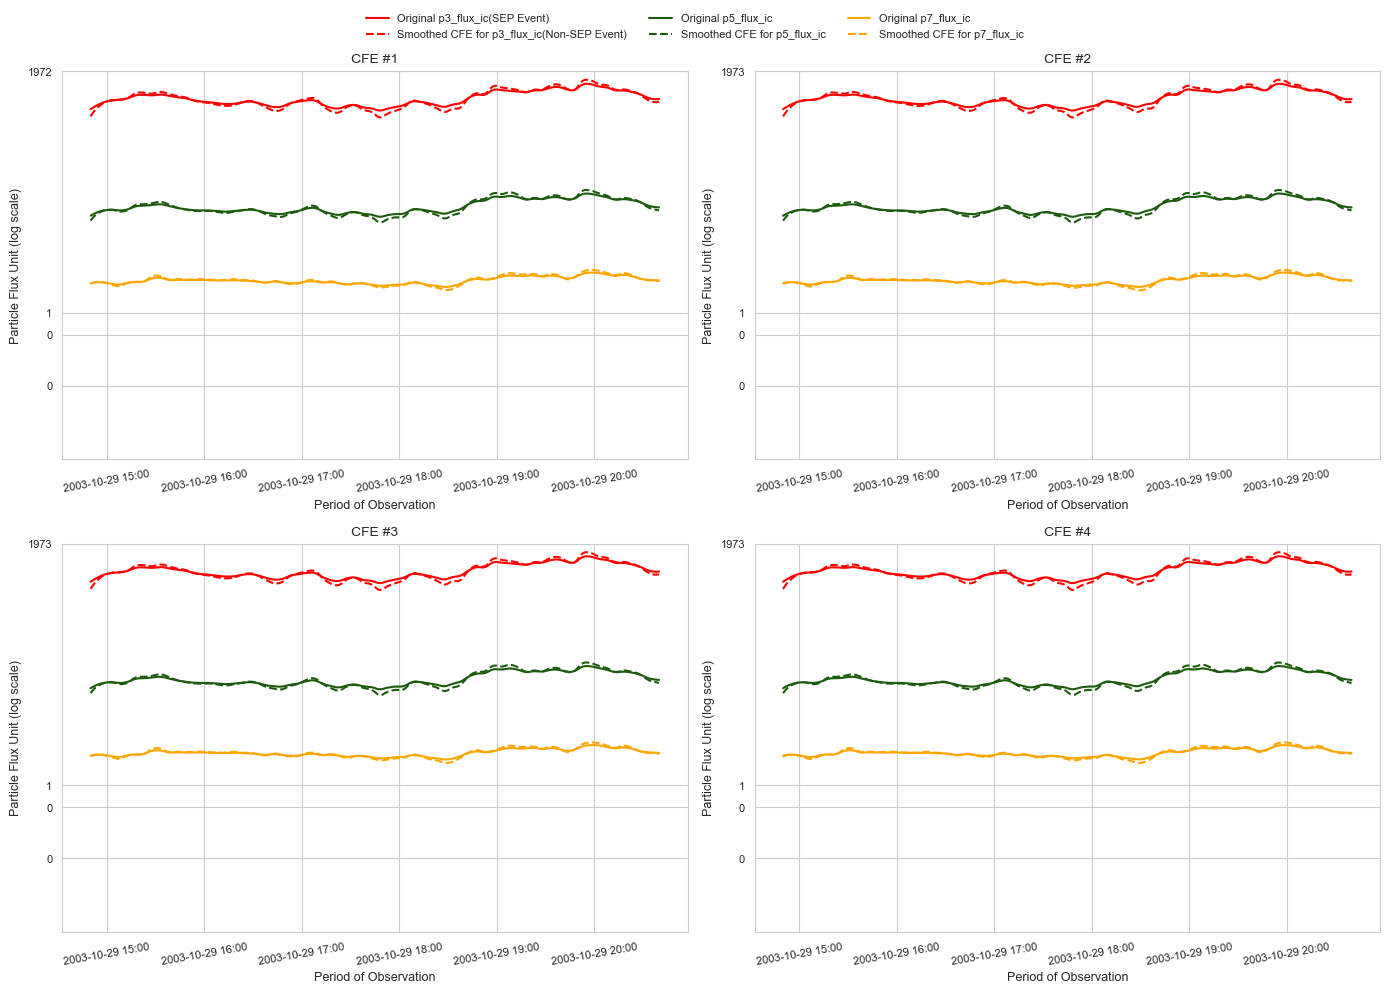

In [129]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

window_size = 10  # Smoothing window

fig, axs = plt.subplots(2, 2, figsize=(14, 10), facecolor='white')
axs = axs.flatten()  # Flatten for easy iteration

for cfe_idx in range(4):
    sample_cfe = df_cfe_exp_genetic_2.iloc[cfe_idx]

    # p3
    flux_type = 'p3_flux_ic'
    df_obs, final_series_p3, original_p3, min_y_p3, max_y_p3 = get_pertubed_series(
        csv_path, sample_cfe=sample_cfe, flux_type=flux_type, slices=slices,
        start_offset_min=300, end_offset_min=660)
    original_p3_smooth = original_p3.rolling(window=window_size, center=True).mean()
    final_series_p3_smooth = pd.Series(final_series_p3).rolling(window=window_size, center=True).mean()

    # p5
    flux_type = 'p5_flux_ic'
    df_obs_1, final_series_p5, original_p5, min_y_p5, max_y_p5 = get_pertubed_series(
        csv_path, sample_cfe=sample_cfe, flux_type=flux_type, slices=slices,
        start_offset_min=300, end_offset_min=660)
    original_p5_smooth = original_p5.rolling(window=window_size, center=True).mean()
    final_series_p5_smooth = pd.Series(final_series_p5).rolling(window=window_size, center=True).mean()

    # p7
    flux_type = 'p7_flux_ic'
    df_obs_2, final_series_p7, original_p7, min_y_p7, max_y_p7 = get_pertubed_series(
        csv_path, sample_cfe=sample_cfe, flux_type=flux_type, slices=slices,
        start_offset_min=300, end_offset_min=660)
    original_p7_smooth = original_p7.rolling(window=window_size, center=True).mean()
    final_series_p7_smooth = pd.Series(final_series_p7).rolling(window=window_size, center=True).mean()

    global_max_y = max(max_y_p3, max_y_p5, max_y_p7)

    ax = axs[cfe_idx]
    ax.set_facecolor('white')

    # Plot lines
    ax.plot(df_obs['time_stamp'], original_p3_smooth, label="Original p3_flux_ic(SEP Event)", color="#FF0000")
    ax.plot(df_obs['time_stamp'], final_series_p3_smooth, label="Smoothed CFE for p3_flux_ic(Non-SEP Event)", color="#FF0000", linestyle='dashed')
    ax.plot(df_obs_1['time_stamp'], original_p5_smooth, label="Original p5_flux_ic", color="#1b5c0c")
    ax.plot(df_obs_1['time_stamp'], final_series_p5_smooth, label="Smoothed CFE for p5_flux_ic", color="#1b5c0c", linestyle='dashed')
    ax.plot(df_obs_2['time_stamp'], original_p7_smooth, label="Original p7_flux_ic", color="#FFA500")
    ax.plot(df_obs_2['time_stamp'], final_series_p7_smooth, label="Smoothed CFE for p7_flux_ic", color="#FFA500", linestyle='dashed')

    ax.set_xlabel("Period of Observation", fontsize=9)
    ax.set_ylabel("Particle Flux Unit (log scale)", fontsize=9)
    ax.set_yscale('log')
    ax.set_ylim(bottom=0.01, top=4)
    ax.set_yticks([0.1, 0.5, 1, global_max_y])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=10, ha='center', fontsize=8)
    plt.setp(ax.get_yticklabels(), fontsize=8)
    # if cfe_idx == 0:
    #     ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False, fontsize=8)
    ax.set_title(f'CFE #{cfe_idx + 1}', fontsize=10)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.995),  # Centered above the grid
    ncol=3,
    frameon=False,
    fontsize=8
)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the legend at the top
plt.show()

wandb.log({"CFE generated using Constrained Dice Class": wandb.Image(fig)})


In [130]:
wandb.finish()